In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn import datasets

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error, downsample_avg, load_and_format_mnist, load_and_format_iris, evaluate_accuracy, evaluate_accuracy_per_class

ModuleNotFoundError: No module named 'tensorflow.python'

In [2]:
#########################################################
################  Parameter definitions #################
#########################################################

random.seed(20)

### Define parameters of classification
M = 5 # how many edges affected per input dimension
# n_classes = 5 # D, how many classes
classes = [0,1,6,7,8]
n_classes = len(classes)
input_dim = 14**2 # D, how many components of each input data
#input_dim = 4

### Define parameters of graph object and initial weights
n_nodes = 100 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

### Define parameters of trainig
n_training_iters = 100 # how many training steps to take
eta = 1 # learning rate (increment of Ej, Bij, Fij)
delta_E = 2 # nuding factor (change in Ej at output nodes during nudging)

############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 
print("Fraction of edges with inputs applied:", M * input_dim / n_edges)


## get input and output inds
output_inds = get_output_inds(n_nodes, n_classes, False)
input_inds = get_input_inds(n_edges, input_dim, M)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)
weight_matrix.lower_output_energies(output_inds, 4) # lower energies at the output nodes to ease training


############################################################
################  Load classification data #################
############################################################

input_data = load_and_format_mnist(classes, 10, 2)
# input_data = load_and_format_mnist(n_classes, 10, 2)
# input_data = load_and_format_iris(n_classes, 10, 2)



Fraction of edges with inputs applied: 0.19797979797979798


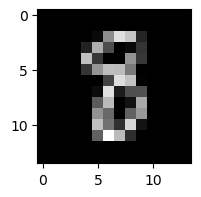

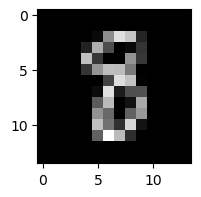

In [7]:
# Create a figure
plt.figure(figsize=(10, 2))



data = np.reshape(next(input_data.training_data[4]),(14,14))
#print(data)
plt.imshow(data, cmap='gray')  # Show in grayscale


plt.show()

plt.figure(figsize=(10, 2))
downsampled_image = downsample_avg(data, m=1)
plt.imshow(downsampled_image, cmap='gray')  # Show in grayscale
plt.show()

In [ ]:
################################################
################  Run training #################
################################################

weight_matrix_orig = copy.deepcopy(weight_matrix) # save original rate matrix 

error_list = [] # track errors during training
accuracy_list = [] # track errors during training
accuracy_stride = 10
delE_stride = 100
delE = 0 * 0.02

for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes) # draw a random class label to present
    # inputs = next(input_data.training_data[class_number]) # get the next data point from the iterator for this class

    try:
        inputs = next(input_data.training_data[class_number])
    except StopIteration:
        input_data.refill_iterators()  # Refill iterators if exhausted
        inputs = next(input_data.training_data[class_number])  # Try again


    ss = weight_matrix.compute_ss_on_inputs(input_inds, inputs) # apply the data as input and get the steady state
    error_list.append(np.linalg.norm(compute_error(ss, input_data, class_number, output_inds))) # save error of this iteration
    
    if (training_iter & accuracy_stride == 0): # compute accuracy for list
        accuracy_list.append(evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 50))
    
    nudged_ss = weight_matrix.compute_nudged_ss(input_data, class_number, input_inds, inputs, output_inds, delta_E) # get the steady state after applying a nudge on this input
    ss_frac = nudged_ss / ss # compute pi_nudge / pi
    
    weight_matrix.update(input_inds, inputs, ss_frac, eta) # update the weight_matrix

    if (training_iter & delE_stride == 0):
        weight_matrix.set_W_mat(weight_matrix.Ej_list - delE, weight_matrix.Bij_list, weight_matrix.Fij_list)
    

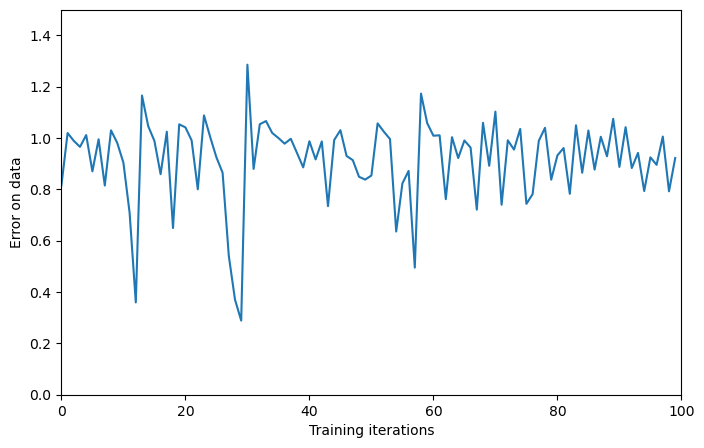

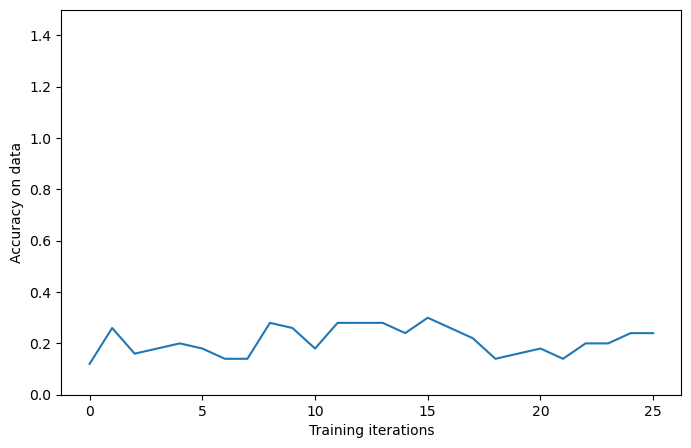

In [4]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
plt.xlim(0,n_training_iters)
plt.show()


### plot the accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_list)
plt.xlabel("Training iterations")
plt.ylabel("Accuracy on data")
plt.ylim(0,1.5)
#plt.xlim(0,n_training_iters / training_stride)
plt.show()




0.252


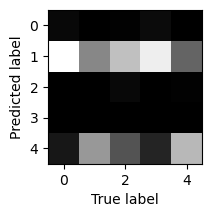

In [7]:

###################################################
################  Get predictions #################
###################################################


print(evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 500))
predictions_per_class = evaluate_accuracy_per_class(weight_matrix, input_inds, input_data, output_inds, 100, n_classes)

plt.figure(figsize=(10, 2))
plt.imshow(predictions_per_class, cmap='gray')  # Show in grayscale
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()


In [9]:
print("a" + "b")

ab
